In [30]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from tqdm.auto import tqdm

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
datapath = "/Users/tommydenezza/Desktop/DeepLearning/LOBnet/data/BenchmarkDatasets_csv/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training"
csv_files = [f for f in os.listdir(datapath) if f.endswith('.csv')]

In [5]:
def split_into_windows(df, window_size=100):
    """
    Split a Pandas DataFrame into non-overlapping windows.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame to be split.
    window_size (int): The size of each window (number of columns).
    
    Returns:
    list of pandas.DataFrame: A list of DataFrame windows.
    """
    num_windows = df.shape[1] // window_size
    windows = []
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        windows.append(df.iloc[:, start:end])
    return windows

In [6]:
X_train_lst = []
Y_train_lst = []
for i,f in enumerate(csv_files):
    print(f"Working on file {i}")
    df = pd.read_csv(os.path.join(datapath, f), header=None)
    X_train_lst += split_into_windows(df.iloc[0:40,:], window_size=100)
    Y_train_lst += split_into_windows(df.iloc[-5:,:]) 

Working on file 0
Working on file 1
Working on file 2
Working on file 3
Working on file 4
Working on file 5
Working on file 6
Working on file 7
Working on file 8


In [9]:
X_data = np.array(X_train_lst).swapaxes(1,2)

# Naively ignore all information about the orderbook in order to get a baseline. Here, we are looking at the deviation from the end of the 
# window to a point 10 events into the future. See pg 13 of https://arxiv.org/pdf/1705.03233
Y_data = np.array(Y_train_lst)[:,-1,-1] 

encoder = OneHotEncoder(sparse_output=False)
Y_data = encoder.fit_transform(Y_data.reshape(-1,1)) 

split_point = int(0.75*len(X_data))
X_train, X_test = X_data[split_point:], X_data[:split_point]
Y_train, Y_test = Y_data[split_point:], Y_data[:split_point]


In [20]:
class NaiveLOBCNN(nn.Module):
    def __init__(self):
        super(NaiveLOBCNN, self).__init__()

        # Conv block see page 5 of https://arxiv.org/pdf/1808.03668
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(1, 2),stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(1, 2),stride=2)
        self.relu2 = nn.ReLU()
        
        self.dropout1 = nn.Dropout2d(p=0.3) # Should have a conversation about what our desired dropout is, set to 3/10 rn

        self.flatten_size = 32 * 10 * 25
        
        # FC 
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 3)  # 3 classes
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Add channel dimension if not present
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
            
        # Convolution blocks
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # Fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x


In [21]:
class OrderBookDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OrderBookDataset(X_train, Y_train)
test_dataset = OrderBookDataset(X_test, Y_test)

batch_size = 32
dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=0  # Increase if you need parallel loading
)

In [25]:
model = NaiveLOBCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_X, batch_y in pbar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(batch_y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100 * correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    print(f'\nEpoch {epoch+1} Summary:')
    print(f'Average Loss: {epoch_loss:.4f}')
    print(f'Accuracy: {epoch_acc:.2f}%\n')

Epoch 1/30: 100%|██████████| 133/133 [00:01<00:00, 105.57it/s, loss=1.0846, acc=38.59%]



Epoch 1 Summary:
Average Loss: 1.0846
Accuracy: 38.59%



Epoch 2/30: 100%|██████████| 133/133 [00:01<00:00, 107.94it/s, loss=1.0744, acc=40.20%]



Epoch 2 Summary:
Average Loss: 1.0744
Accuracy: 40.20%



Epoch 3/30: 100%|██████████| 133/133 [00:01<00:00, 114.56it/s, loss=1.0570, acc=43.52%]



Epoch 3 Summary:
Average Loss: 1.0570
Accuracy: 43.52%



Epoch 4/30: 100%|██████████| 133/133 [00:01<00:00, 109.55it/s, loss=1.0418, acc=45.13%]



Epoch 4 Summary:
Average Loss: 1.0418
Accuracy: 45.13%



Epoch 5/30: 100%|██████████| 133/133 [00:01<00:00, 120.41it/s, loss=1.0300, acc=47.80%]



Epoch 5 Summary:
Average Loss: 1.0300
Accuracy: 47.80%



Epoch 6/30: 100%|██████████| 133/133 [00:01<00:00, 107.82it/s, loss=1.0258, acc=46.90%]



Epoch 6 Summary:
Average Loss: 1.0258
Accuracy: 46.90%



Epoch 7/30: 100%|██████████| 133/133 [00:01<00:00, 114.57it/s, loss=1.0159, acc=49.24%]



Epoch 7 Summary:
Average Loss: 1.0159
Accuracy: 49.24%



Epoch 8/30: 100%|██████████| 133/133 [00:01<00:00, 111.10it/s, loss=1.0011, acc=51.73%]



Epoch 8 Summary:
Average Loss: 1.0011
Accuracy: 51.73%



Epoch 9/30: 100%|██████████| 133/133 [00:01<00:00, 113.72it/s, loss=0.9921, acc=52.96%]



Epoch 9 Summary:
Average Loss: 0.9921
Accuracy: 52.96%



Epoch 10/30: 100%|██████████| 133/133 [00:01<00:00, 111.47it/s, loss=0.9853, acc=53.95%]



Epoch 10 Summary:
Average Loss: 0.9853
Accuracy: 53.95%



Epoch 11/30: 100%|██████████| 133/133 [00:01<00:00, 113.71it/s, loss=0.9813, acc=54.76%]



Epoch 11 Summary:
Average Loss: 0.9813
Accuracy: 54.76%



Epoch 12/30: 100%|██████████| 133/133 [00:01<00:00, 109.75it/s, loss=0.9631, acc=57.15%]



Epoch 12 Summary:
Average Loss: 0.9631
Accuracy: 57.15%



Epoch 13/30: 100%|██████████| 133/133 [00:01<00:00, 116.64it/s, loss=0.9544, acc=58.07%]



Epoch 13 Summary:
Average Loss: 0.9544
Accuracy: 58.07%



Epoch 14/30: 100%|██████████| 133/133 [00:01<00:00, 109.58it/s, loss=0.9443, acc=59.58%]



Epoch 14 Summary:
Average Loss: 0.9443
Accuracy: 59.58%



Epoch 15/30: 100%|██████████| 133/133 [00:01<00:00, 117.68it/s, loss=0.9171, acc=62.71%]



Epoch 15 Summary:
Average Loss: 0.9171
Accuracy: 62.71%



Epoch 16/30: 100%|██████████| 133/133 [00:01<00:00, 115.86it/s, loss=0.9092, acc=63.44%]



Epoch 16 Summary:
Average Loss: 0.9092
Accuracy: 63.44%



Epoch 17/30: 100%|██████████| 133/133 [00:01<00:00, 113.14it/s, loss=0.8989, acc=64.91%]



Epoch 17 Summary:
Average Loss: 0.8989
Accuracy: 64.91%



Epoch 18/30: 100%|██████████| 133/133 [00:01<00:00, 118.42it/s, loss=0.9014, acc=64.67%]



Epoch 18 Summary:
Average Loss: 0.9014
Accuracy: 64.67%



Epoch 19/30: 100%|██████████| 133/133 [00:01<00:00, 112.13it/s, loss=0.8785, acc=68.32%]



Epoch 19 Summary:
Average Loss: 0.8785
Accuracy: 68.32%



Epoch 20/30: 100%|██████████| 133/133 [00:01<00:00, 114.40it/s, loss=0.8523, acc=70.52%]



Epoch 20 Summary:
Average Loss: 0.8523
Accuracy: 70.52%



Epoch 21/30: 100%|██████████| 133/133 [00:01<00:00, 111.84it/s, loss=0.8292, acc=73.38%]



Epoch 21 Summary:
Average Loss: 0.8292
Accuracy: 73.38%



Epoch 22/30: 100%|██████████| 133/133 [00:01<00:00, 113.82it/s, loss=0.8091, acc=75.44%]



Epoch 22 Summary:
Average Loss: 0.8091
Accuracy: 75.44%



Epoch 23/30: 100%|██████████| 133/133 [00:01<00:00, 111.15it/s, loss=0.7974, acc=76.34%]



Epoch 23 Summary:
Average Loss: 0.7974
Accuracy: 76.34%



Epoch 24/30: 100%|██████████| 133/133 [00:01<00:00, 113.84it/s, loss=0.7844, acc=77.35%]



Epoch 24 Summary:
Average Loss: 0.7844
Accuracy: 77.35%



Epoch 25/30: 100%|██████████| 133/133 [00:01<00:00, 110.96it/s, loss=0.7800, acc=77.95%]



Epoch 25 Summary:
Average Loss: 0.7800
Accuracy: 77.95%



Epoch 26/30: 100%|██████████| 133/133 [00:01<00:00, 115.13it/s, loss=0.7680, acc=79.27%]



Epoch 26 Summary:
Average Loss: 0.7680
Accuracy: 79.27%



Epoch 27/30: 100%|██████████| 133/133 [00:01<00:00, 112.70it/s, loss=0.7601, acc=79.58%]



Epoch 27 Summary:
Average Loss: 0.7601
Accuracy: 79.58%



Epoch 28/30: 100%|██████████| 133/133 [00:01<00:00, 114.25it/s, loss=0.7492, acc=80.90%]



Epoch 28 Summary:
Average Loss: 0.7492
Accuracy: 80.90%



Epoch 29/30: 100%|██████████| 133/133 [00:01<00:00, 112.31it/s, loss=0.7333, acc=82.49%]



Epoch 29 Summary:
Average Loss: 0.7333
Accuracy: 82.49%



Epoch 30/30: 100%|██████████| 133/133 [00:01<00:00, 106.90it/s, loss=0.7274, acc=83.10%]


Epoch 30 Summary:
Average Loss: 0.7274
Accuracy: 83.10%



In [26]:
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=0  # Increase if needed for parallel data loading
)

model.eval()
pred_batches = tqdm(test_dataloader, desc='Running Test Predictions')

all_predictions = []
all_labels = []

for X_batch, y_batch in pred_batches:
    
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    
    test_output = model(X_batch)
    _, test_pred = torch.max(test_output.data, 1)  # Predicted class indices
    
    if y_batch.ndim > 1:
        _, test_labels = torch.max(y_batch.data, 1)
    else:
        test_labels = y_batch 
    
    all_predictions.extend(test_pred.cpu().numpy())
    all_labels.extend(test_labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = (all_predictions == all_labels).mean() * 100
print(f"Test Accuracy: {accuracy:.2f}%")



Running Test Predictions: 100%|██████████| 397/397 [00:00<00:00, 603.61it/s]

Test Accuracy: 46.45%


In [43]:
print(pd.DataFrame(all_labels).value_counts().to_list())

[5079, 5053, 2543]


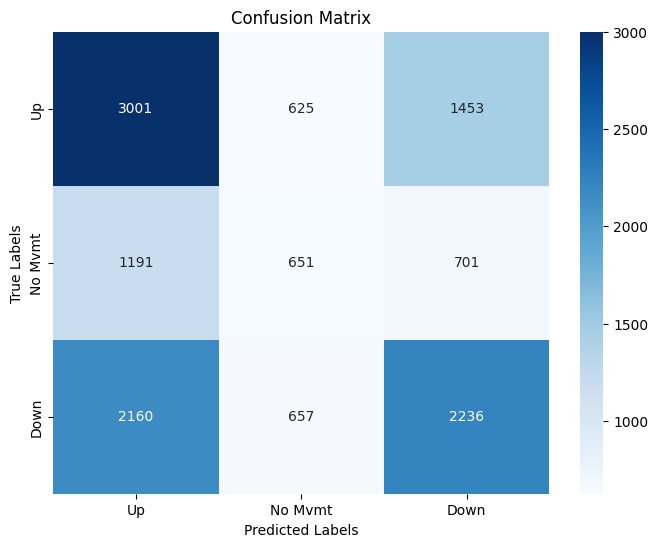

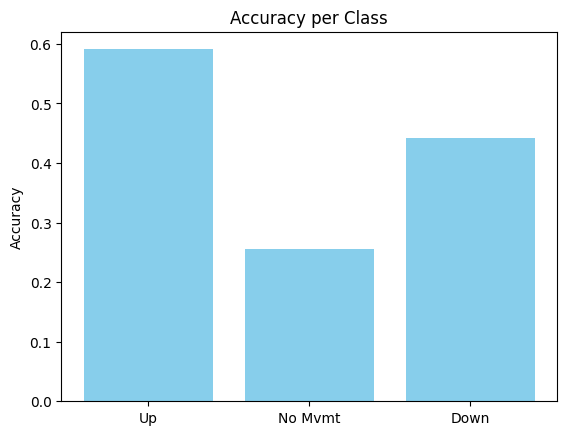

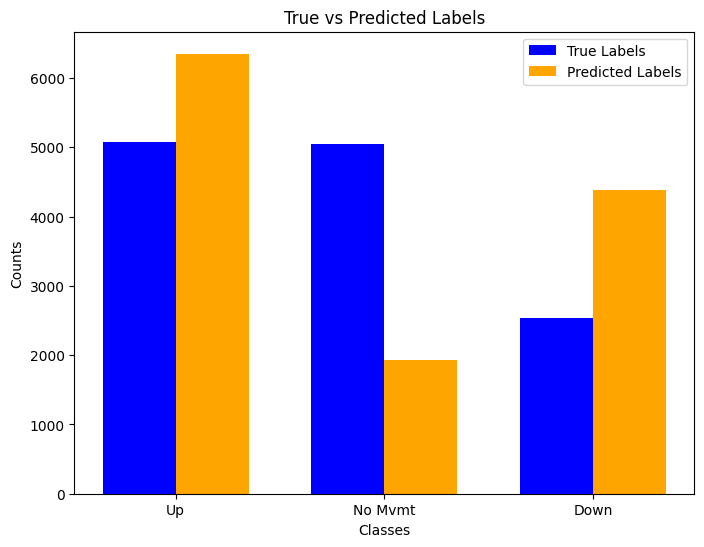

In [44]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Up', 'No Mvmt', 'Down'], yticklabels=['Up', 'No Mvmt', 'Down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Accuracy per Class Bar Chart
class_accuracy = np.diagonal(cm) / cm.sum(axis=1)
classes = ['Up', 'No Mvmt', 'Down']
plt.bar(classes, class_accuracy, color='skyblue')
plt.title('Accuracy per Class')
plt.ylabel('Accuracy')
plt.show()

# Prediction and Ground Truth Side by Side
true_counts = pd.DataFrame(all_labels).value_counts().to_list()
pred_counts = pd.DataFrame(all_predictions).value_counts().to_list()
# Set bar width and positions for the pairs of bars
bar_width = 0.35
index = np.arange(len(classes))

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the bars
plt.bar(index - bar_width/2, true_counts, bar_width, label='True Labels', color='b')
plt.bar(index + bar_width/2, predicted_counts, bar_width, label='Predicted Labels', color='orange')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('True vs Predicted Labels')
plt.xticks(index, classes)
plt.legend()

# Show the plot
plt.show()